# ***Supervised Classification Challenge***

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Import Data

In [23]:
df = pd.read_csv('data/TrainOnMe.csv', index_col=0)
X_eval = pd.read_csv('data/EvaluateOnMe.csv', index_col=0)

## Separating in training set and validation set before preprocessing (to avoid leakage)

In [24]:
X, y = df.drop(columns=['y']), df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

df = pd.concat([y_train, X_train], axis=1)
df_test = pd.concat([y_test, X_test], axis=1)

## Data Visualization

### Information

In [25]:
print('Training info:')
df.info()
print('Test info:')
df_test.info()
print('Eval info:')

Training info:
<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 1905 to 2775
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       4000 non-null   object 
 1   x1      4000 non-null   float64
 2   x2      4000 non-null   float64
 3   x3      4000 non-null   float64
 4   x4      4000 non-null   float64
 5   x5      4000 non-null   float64
 6   x6      4000 non-null   float64
 7   x7      4000 non-null   object 
 8   x8      4000 non-null   float64
 9   x9      4000 non-null   float64
 10  x10     4000 non-null   float64
 11  x11     4000 non-null   float64
 12  x12     4000 non-null   bool   
 13  x13     4000 non-null   float64
dtypes: bool(1), float64(11), object(2)
memory usage: 441.4+ KB
Test info:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3279 to 560
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1000 non-null   object

### Evaluation dataset information

In [26]:
X_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 5000 to 14999
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      10000 non-null  float64
 1   x2      10000 non-null  float64
 2   x3      10000 non-null  float64
 3   x4      10000 non-null  float64
 4   x5      10000 non-null  float64
 5   x6      10000 non-null  float64
 6   x7      10000 non-null  object 
 7   x8      10000 non-null  float64
 8   x9      10000 non-null  float64
 9   x10     10000 non-null  float64
 10  x11     10000 non-null  float64
 11  x12     10000 non-null  bool   
 12  x13     10000 non-null  float64
dtypes: bool(1), float64(11), object(1)
memory usage: 1.0+ MB


### Head

In [27]:
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
1905,Tesla,199.71905,-0.23942,-96.79836,-1.05739,229.65314,-120.79823,EBIT/Wh,-0.81998,0.80924,5.40228,3.50679,True,950.19605
1008,Tesla,199.29957,0.81416,-100.12765,-1.04991,229.24534,-119.20239,EBIT/Wh,-0.45201,1.09671,13.87670,-5.56440,True,946.43404
3755,SpaceX,200.32315,-0.10698,-105.68875,-1.06469,230.24013,-119.85288,Q3,-0.09294,0.48817,9.88639,4.88111,True,948.77138
891,Tesla,200.81332,0.26839,-104.84861,-1.04766,230.76334,-119.57010,Q3,-1.82866,0.03110,12.62979,-4.39333,True,951.64232
407,TwitterX,197.46846,-0.13880,-98.31477,-1.05832,227.39909,-120.56321,AI,-0.82343,-0.07924,12.96832,0.25628,True,938.18493


3 columns with non-numerical values -> we will fix it with encoding

### Label encoding

In [28]:
label_encoders = {}
columns_to_encode = ['y', 'x7', 'x12']

for col in columns_to_encode:
    le = LabelEncoder()  # create a new LabelEncoder for each column
    df[col] = le.fit_transform(df[col])  # fit and transform on training data
    label_encoders[col] = le
    
for col in columns_to_encode:
    if col in df_test.columns:
        df_test[col] = label_encoders[col].transform(df_test[col])  # use the stored encoder to transform test data

for col in columns_to_encode:
    if col in X_eval.columns:
        X_eval[col] = label_encoders[col].transform(X_eval[col])  # use the stored encoder to transform evaluation data

df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
1905,1,199.71905,-0.23942,-96.79836,-1.05739,229.65314,-120.79823,1,-0.81998,0.80924,5.40228,3.50679,0,950.19605
1008,1,199.29957,0.81416,-100.12765,-1.04991,229.24534,-119.20239,1,-0.45201,1.09671,13.87670,-5.56440,0,946.43404
3755,0,200.32315,-0.10698,-105.68875,-1.06469,230.24013,-119.85288,4,-0.09294,0.48817,9.88639,4.88111,0,948.77138
891,1,200.81332,0.26839,-104.84861,-1.04766,230.76334,-119.57010,4,-1.82866,0.03110,12.62979,-4.39333,0,951.64232
407,2,197.46846,-0.13880,-98.31477,-1.05832,227.39909,-120.56321,0,-0.82343,-0.07924,12.96832,0.25628,0,938.18493


### Stat

In [29]:
df.iloc[:,1:].describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.0,4000.000000
mean,200.008269,0.021812,-99.981566,-1.053051,229.947397,-121.005166,2.155250,0.009281,-0.003401,11.074248,-0.411421,0.0,950.050562
std,1.013157,0.706712,3.197412,0.006605,1.013081,1.789767,1.557483,1.212996,1.237383,2.727078,3.343933,0.0,4.982253
min,196.519800,-2.546980,-112.554330,-1.070990,226.472260,-127.403190,0.000000,-4.349350,-5.140990,0.672290,-11.232970,0.0,932.910080
25%,199.326012,-0.462295,-102.136162,-1.057323,229.267462,-122.234713,1.000000,-0.729685,-0.736695,9.235180,-2.657782,0.0,946.701728
50%,199.998385,0.023745,-100.033205,-1.053320,229.939210,-120.992370,2.000000,-0.010345,0.006390,11.059680,-0.640005,0.0,950.019745
75%,200.710320,0.508390,-97.906760,-1.048235,230.647735,-119.801488,4.000000,0.746580,0.768343,12.844823,1.761027,0.0,953.369295
max,203.424740,2.225160,-87.614030,-1.039130,233.358560,-115.008580,4.000000,4.596640,5.070340,26.156030,11.423080,0.0,968.239710


### Unique values

In [30]:
df.nunique()

y         3
x1     3982
x2     3967
x3     3995
x4     1998
x5     3983
x6     3986
x7        5
x8     3982
x9     3990
x10    3991
x11    3995
x12       1
x13    3994
dtype: int64

### Class count

In [31]:
print('Value count in training set:')
print(df['y'].value_counts())
print('Value count in test set:')
print(df_test['y'].value_counts())

Value count in training set:
y
1    1670
0    1246
2    1084
Name: count, dtype: int64
Value count in test set:
y
1    403
0    338
2    259
Name: count, dtype: int64


### Fixing class imbalance with oversampling

In [32]:
'''
smote = SMOTE(random_state=32)
X, y = df.drop(columns=['y']), df['y']
X_resampled, y_resampled = smote.fit_resample(X, y)

df = pd.concat([y_resampled, X_resampled], axis=1)

df['y'].value_counts()
'''

"\nsmote = SMOTE(random_state=32)\nX, y = df.drop(columns=['y']), df['y']\nX_resampled, y_resampled = smote.fit_resample(X, y)\n\ndf = pd.concat([y_resampled, X_resampled], axis=1)\n\ndf['y'].value_counts()\n"

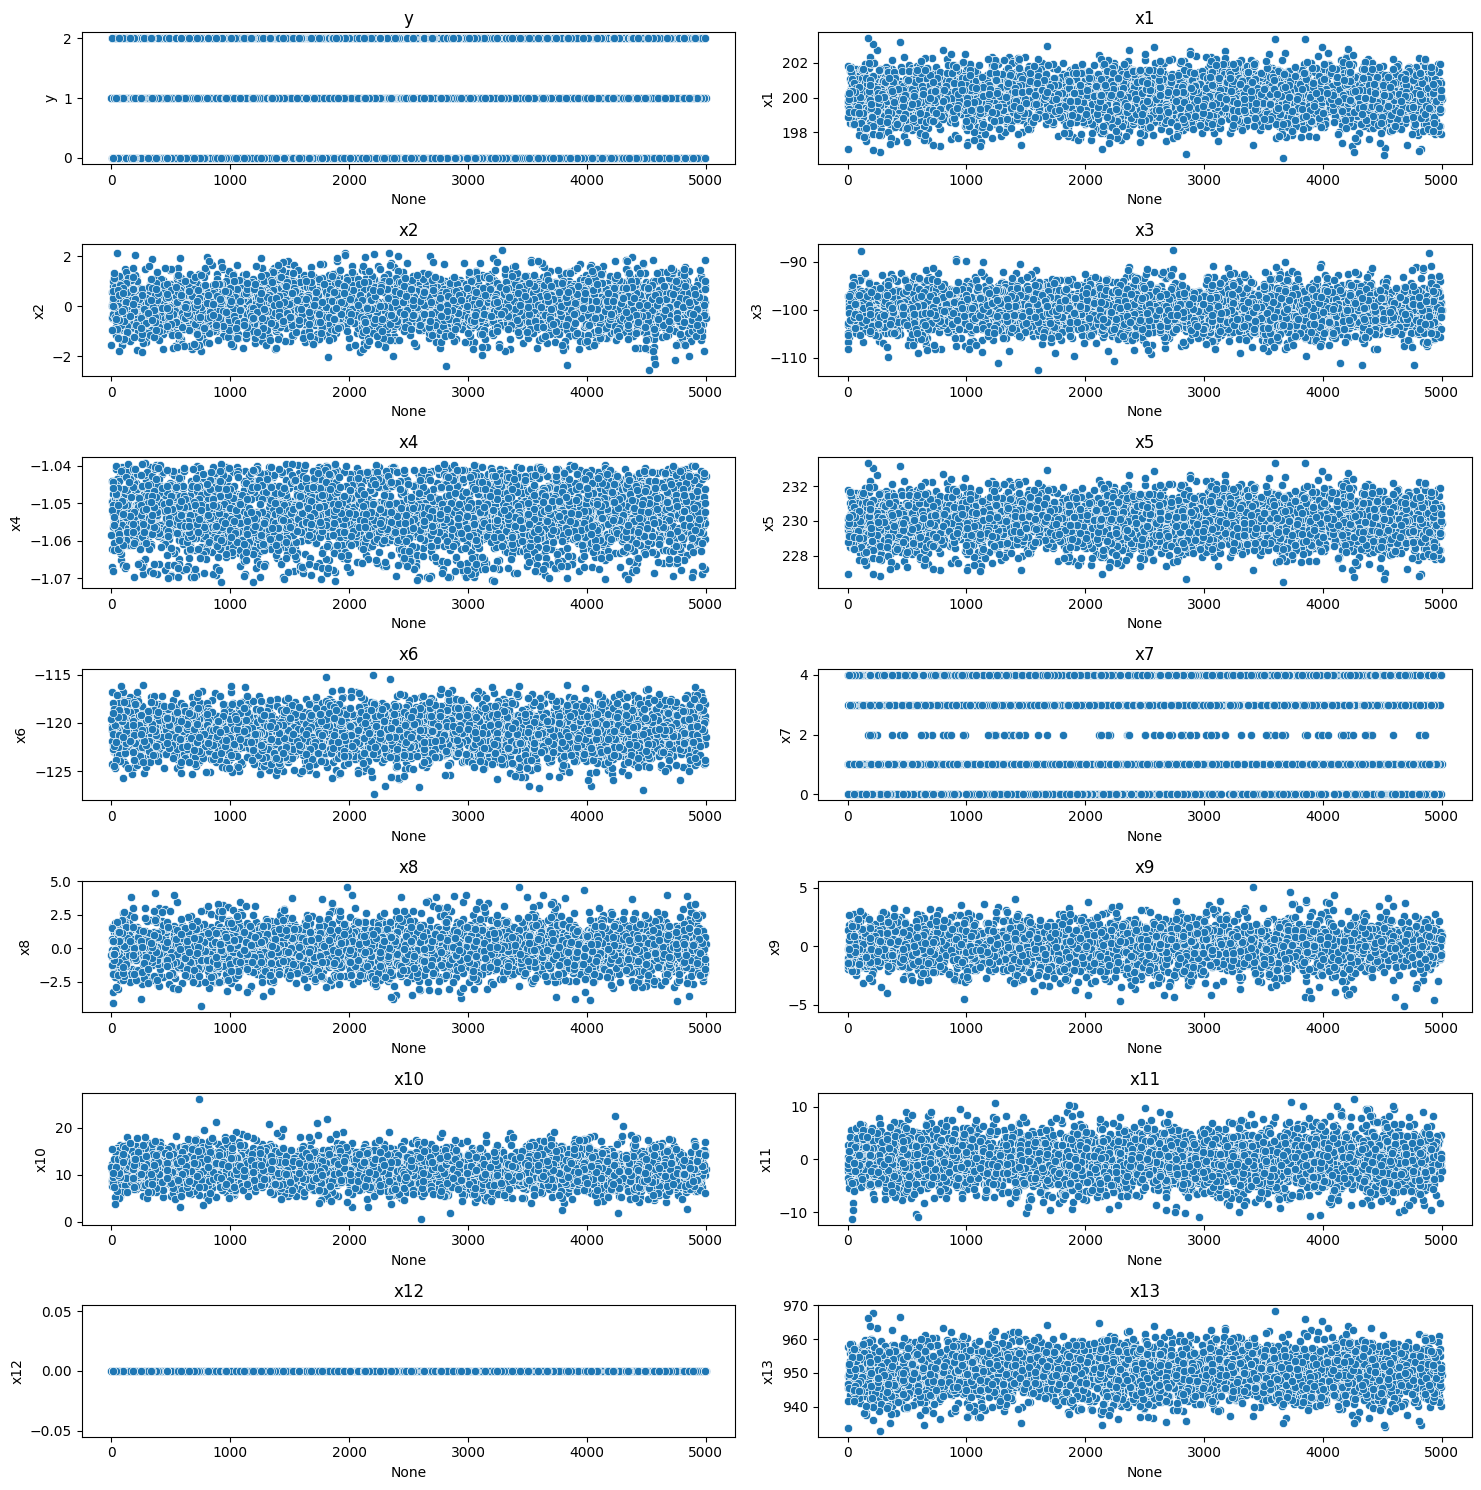

In [33]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
axs = axs.flatten() # flatten the 4x4 array of axes to loop over it easily
for i, col in enumerate(df.columns):
    sns.scatterplot(data=df, x=df.index, y=col, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

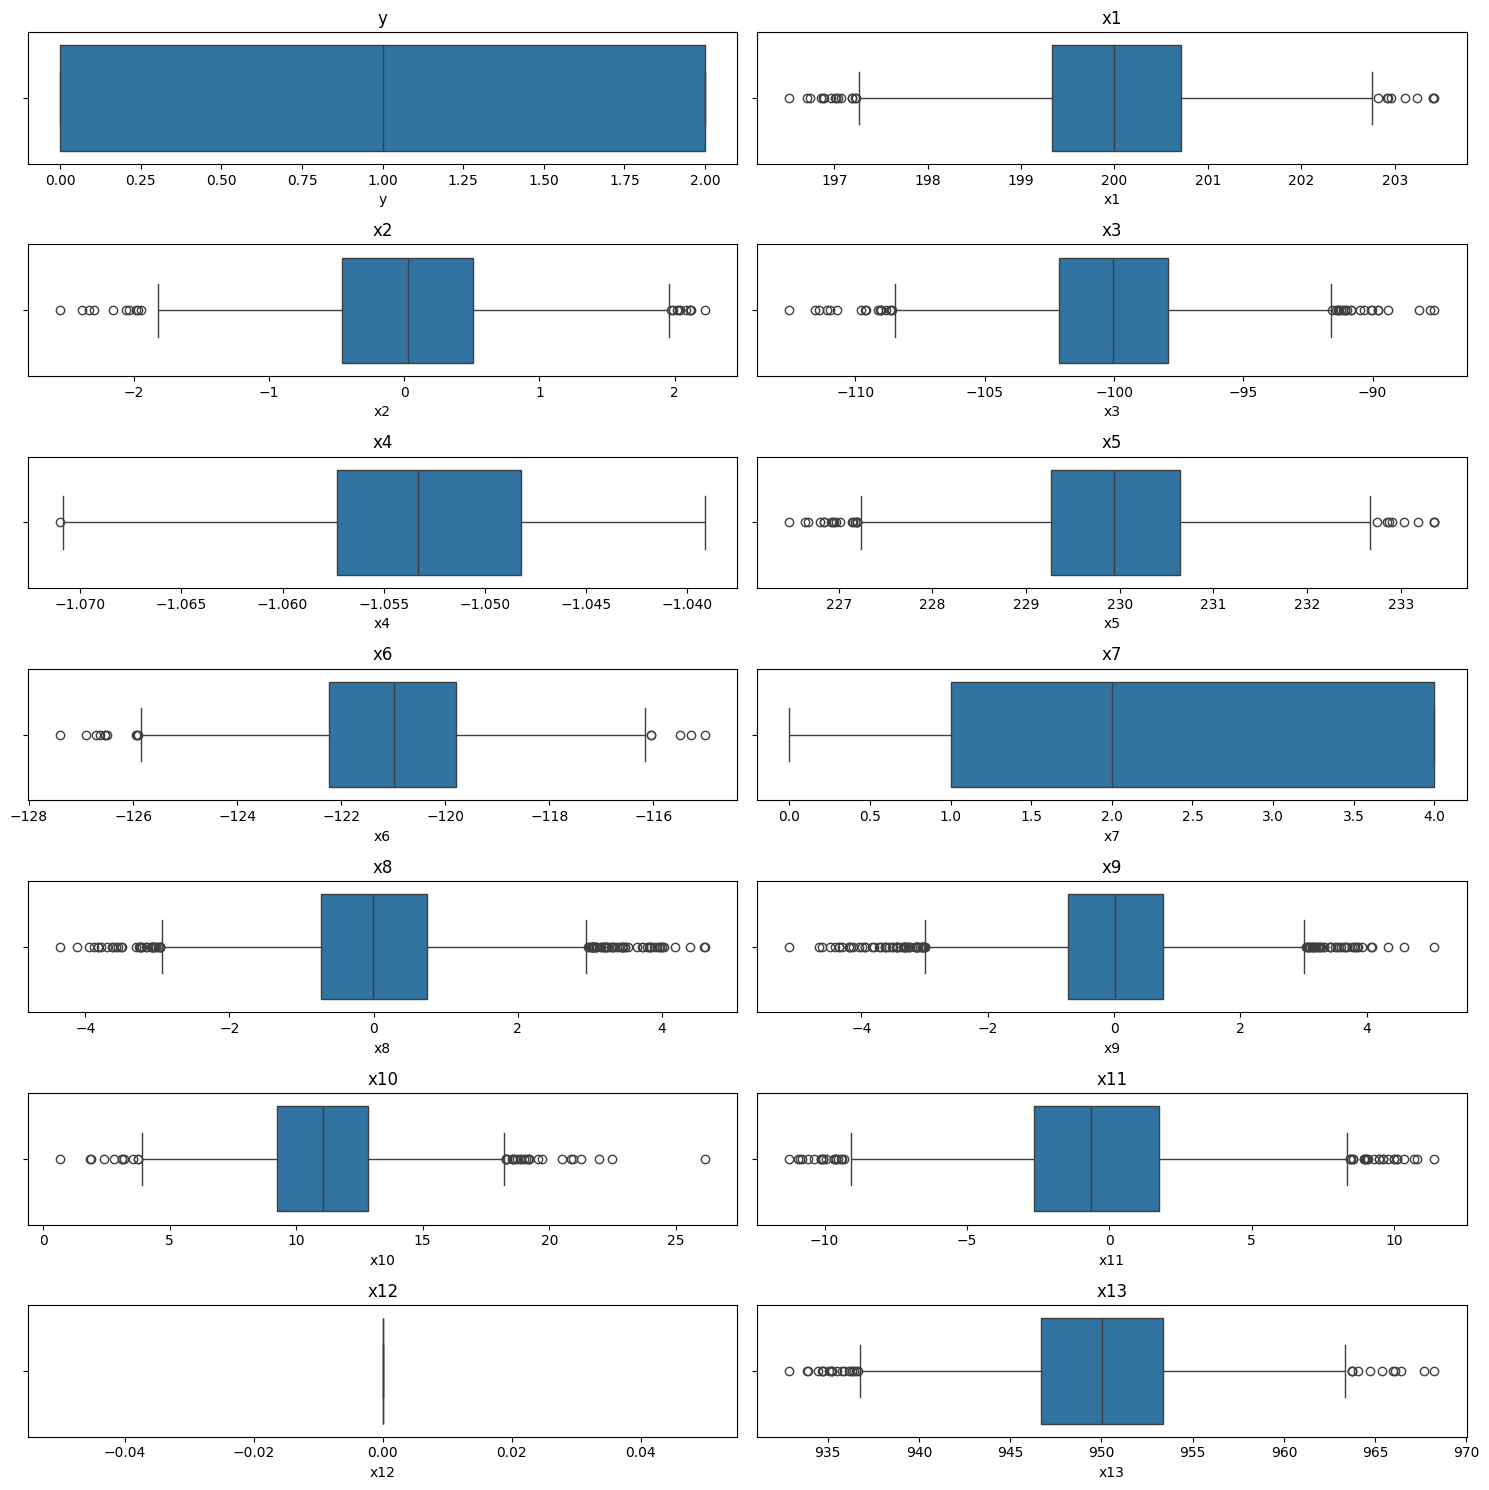

In [34]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
axs = axs.flatten() # flatten the 4x4 array of axes to loop over it easily
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axs[i])  # use ax=axs[i] to plot on the respective subplot
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

x12 is only 0 (True) -> we will remove it

### Correlation

<Axes: >

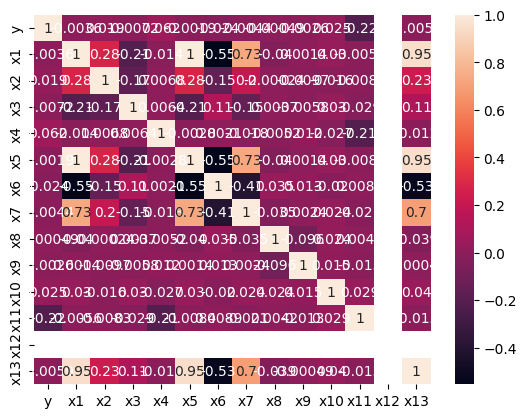

In [35]:
sns.heatmap(df.corr(), annot=True)

Some features are highly correlated -> we could use PCA

## Data preprocessing

### Transforming outliers

In [36]:
def outliers_transform(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 2 * IQR
    higher_limit = Q3 + 2 * IQR
    
    return df[col].apply(lambda value: df[col].median() if value < lower_limit or value > higher_limit else value)
    
for col in df.columns:
    if col != 'y':
        df[col] = outliers_transform(df, col)
        df_test[col] = outliers_transform(df_test, col)
        X_eval[col] = outliers_transform(X_eval, col)

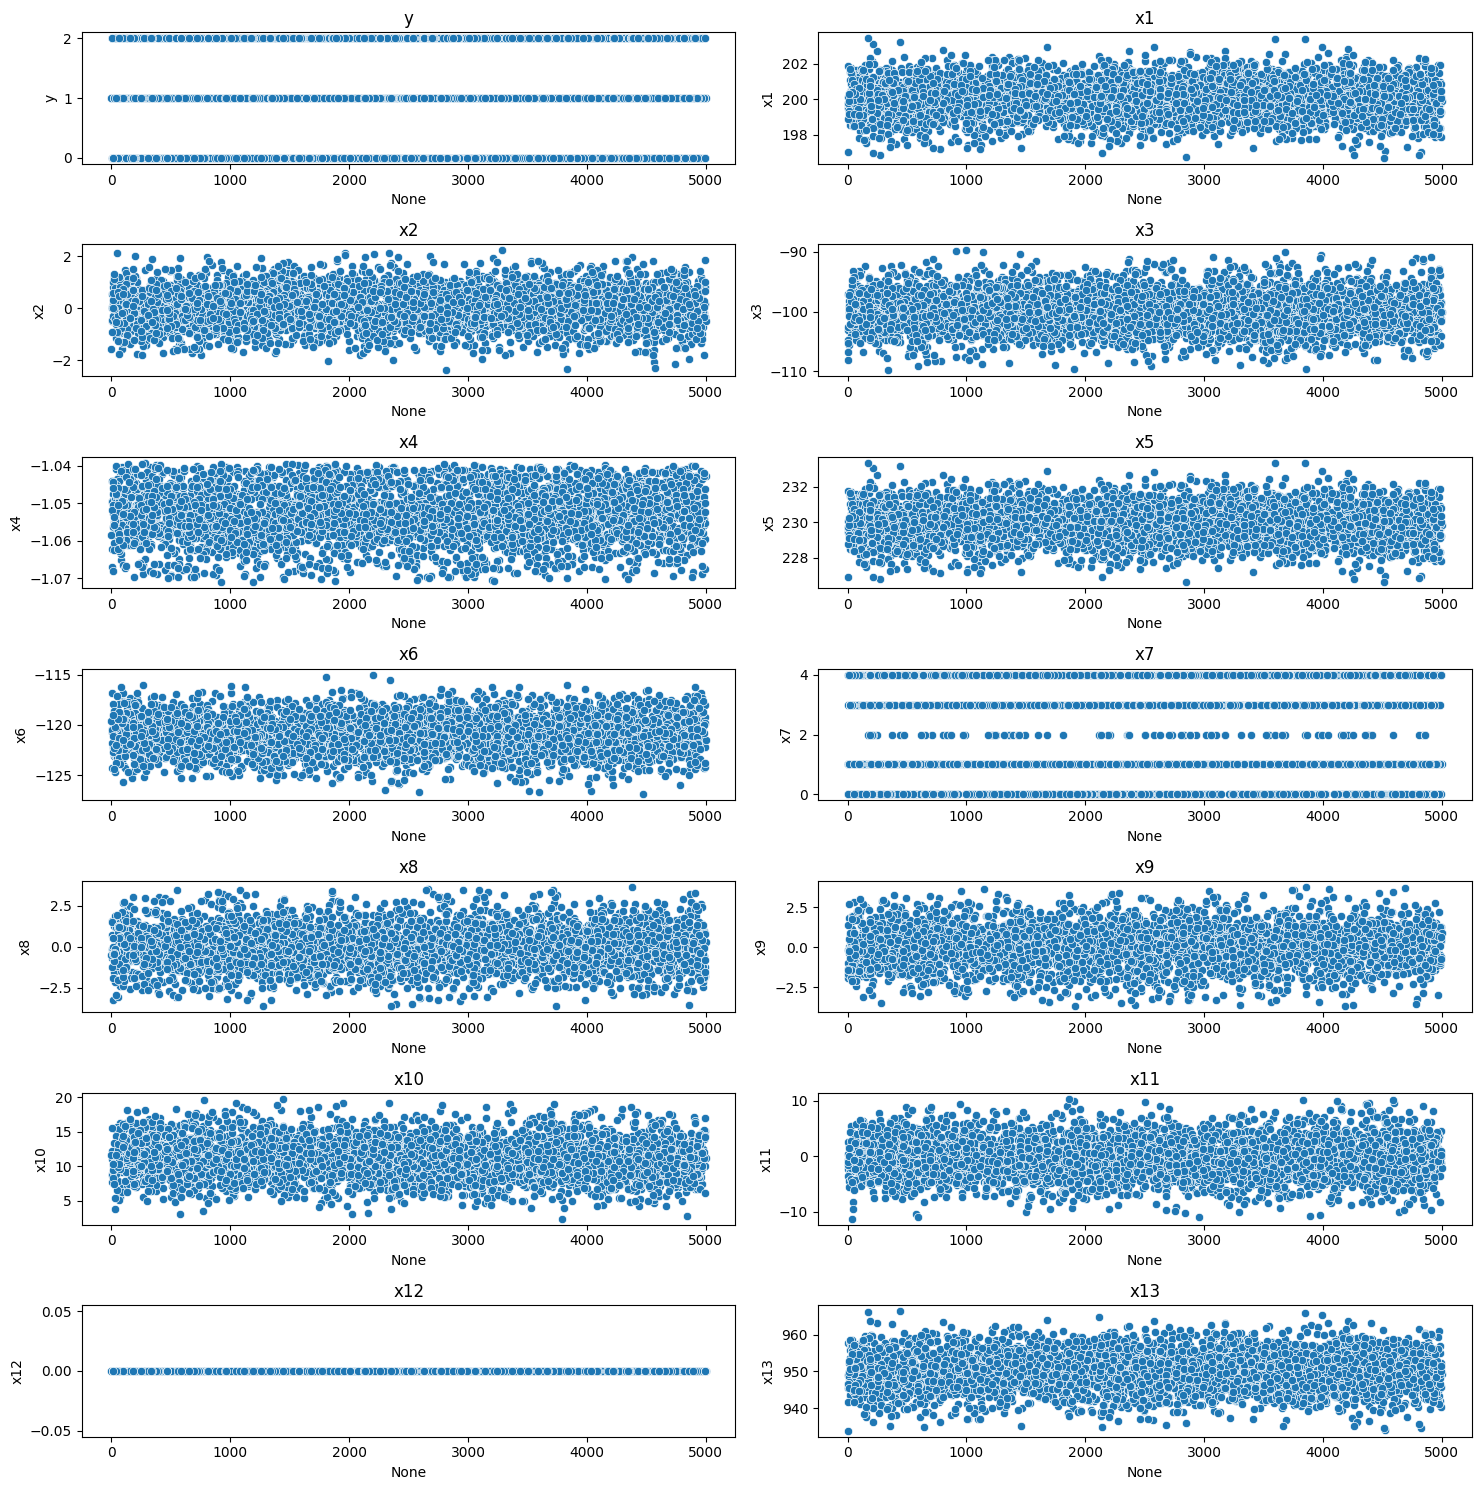

In [37]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
axs = axs.flatten() # flatten the 4x4 array of axes to loop over it easily
for i, col in enumerate(df.columns):
    sns.scatterplot(data=df, x=df.index, y=col, ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

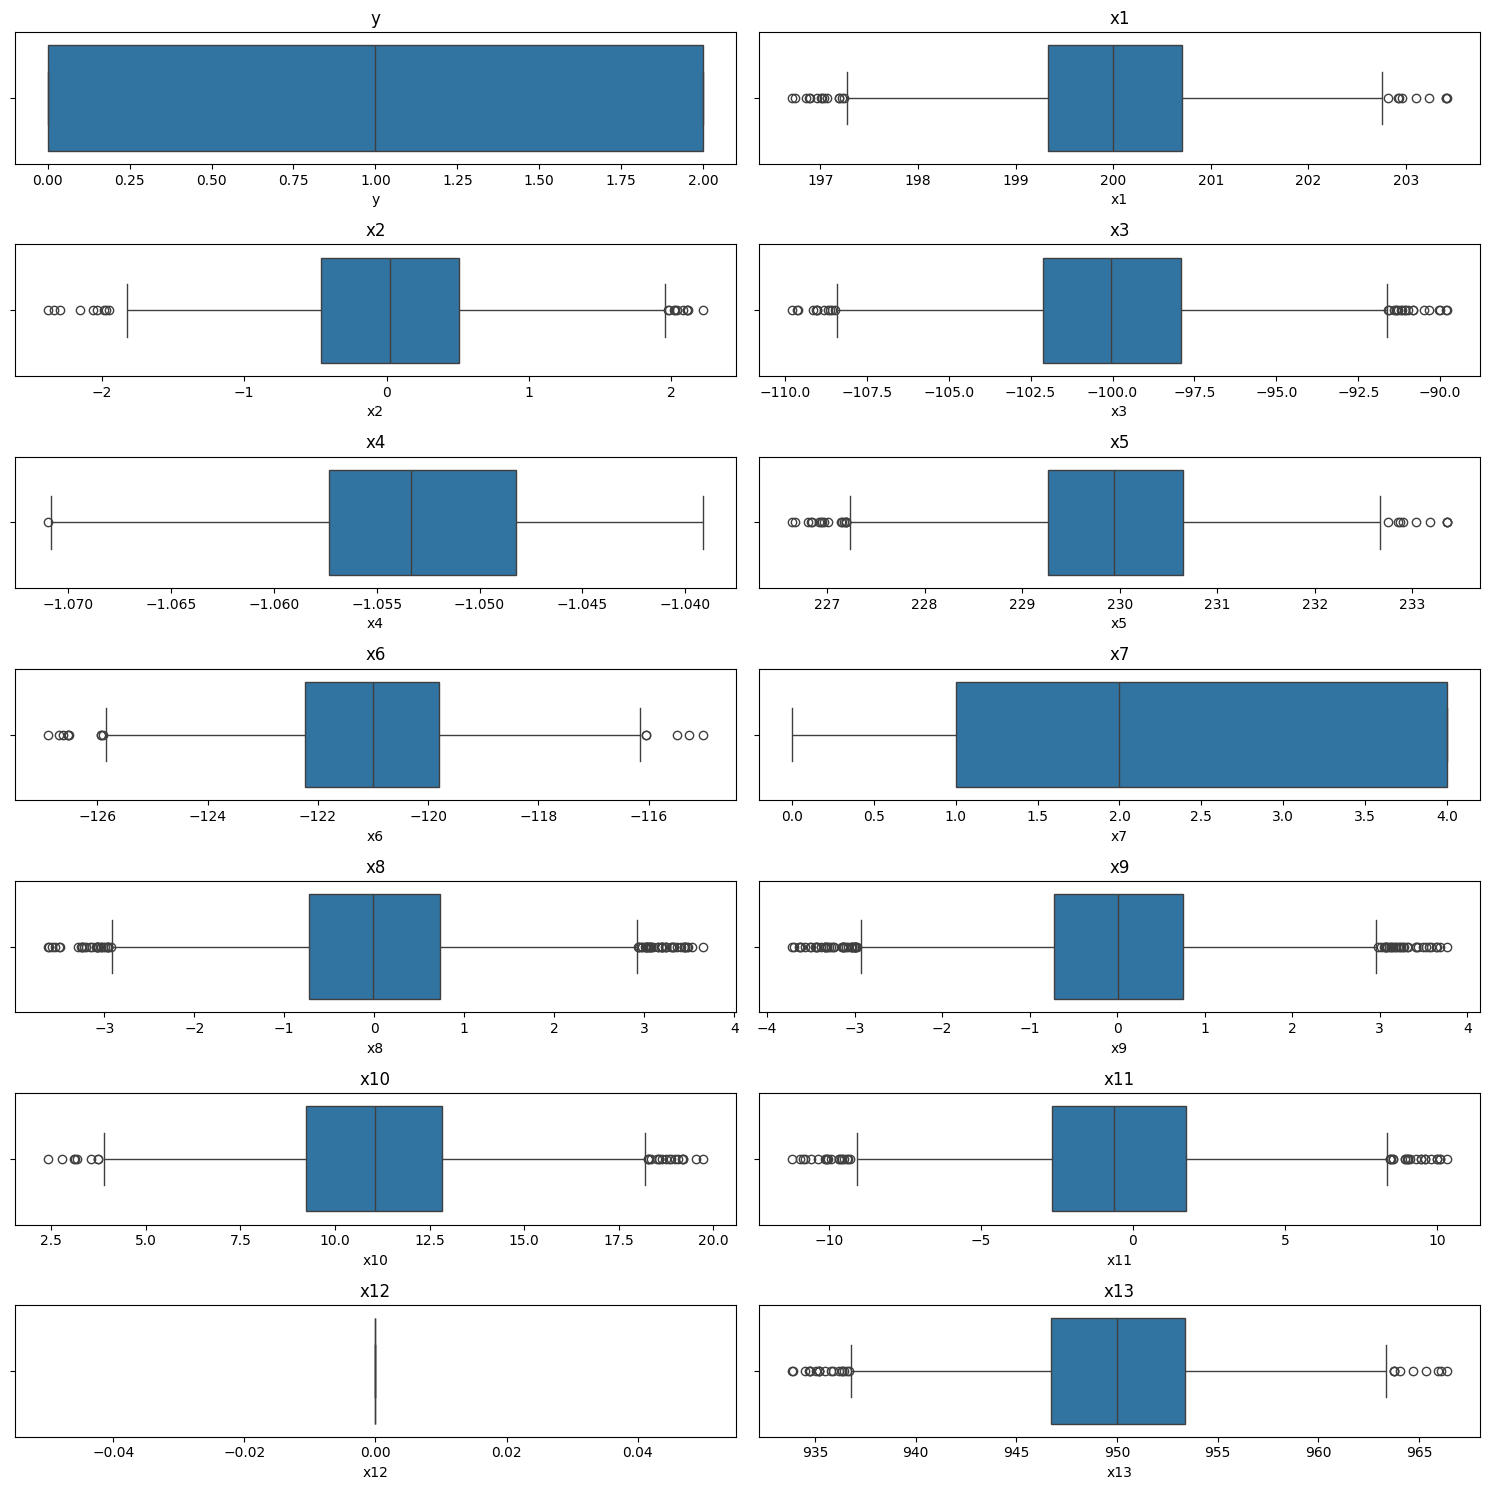

In [38]:
fig, axs = plt.subplots(7, 2, figsize=(15, 15))
axs = axs.flatten() # flatten the 4x4 array of axes to loop over it easily
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axs[i])  # use ax=axs[i] to plot on the respective subplot
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

### Standardization

In [39]:
scaler = StandardScaler()

X_train, y_train = df.drop(columns=['y']), df['y']
X_test, y_test = df_test.drop(columns=['y']), df_test['y']

X_train_pp = scaler.fit_transform(X_train)

X_test_pp = scaler.transform(X_test)
X_eval_pp = scaler.transform(X_eval)

X_train = pd.DataFrame(X_train_pp, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_pp, columns=X_test.columns, index=X_test.index)
X_eval = pd.DataFrame(X_eval_pp, columns=X_eval.columns, index=X_eval.index)

X_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13
1905,-0.286783,-0.371214,1.010679,-0.657016,-0.291779,0.114925,-0.741834,-0.700350,0.678003,-2.116684,1.179652,0.0,0.030290
1008,-0.701482,1.122262,-0.048127,0.475572,-0.694958,1.008112,-0.741834,-0.385701,0.920489,1.052535,-1.545337,0.0,-0.728470
3755,0.310433,-0.183477,-1.816709,-1.762349,0.288559,0.644034,1.184591,-0.078663,0.407175,-0.439740,1.592499,0.0,-0.257052
891,0.795017,0.348619,-1.549522,0.816257,0.805840,0.802305,1.184591,-1.562865,0.021629,0.586222,-1.193547,0.0,0.321988
407,-2.511725,-0.228583,0.528419,-0.797832,-2.520286,0.246465,-1.383976,-0.703300,-0.071445,0.712824,0.203198,0.0,-2.392234


### Feature selection based on visualization

In [40]:
X_train.drop(columns=['x12'], inplace=True)
X_test.drop(columns=['x12'], inplace=True)
X_eval.drop(columns=['x12'], inplace=True)

X_train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x13
1905,-0.286783,-0.371214,1.010679,-0.657016,-0.291779,0.114925,-0.741834,-0.700350,0.678003,-2.116684,1.179652,0.030290
1008,-0.701482,1.122262,-0.048127,0.475572,-0.694958,1.008112,-0.741834,-0.385701,0.920489,1.052535,-1.545337,-0.728470
3755,0.310433,-0.183477,-1.816709,-1.762349,0.288559,0.644034,1.184591,-0.078663,0.407175,-0.439740,1.592499,-0.257052
891,0.795017,0.348619,-1.549522,0.816257,0.805840,0.802305,1.184591,-1.562865,0.021629,0.586222,-1.193547,0.321988
407,-2.511725,-0.228583,0.528419,-0.797832,-2.520286,0.246465,-1.383976,-0.703300,-0.071445,0.712824,0.203198,-2.392234


### Feature selection with LASSO

In [41]:
lasso = Lasso(alpha=0.001)  
lasso.fit(X_train, y_train)

coef = lasso.coef_
print("Coefficients: ", coef)

selected_features = X.columns[coef != 0]
print("Selected Features: ", selected_features)

X_train = X_train[selected_features]
X_test = X_test[selected_features]
print("New dataset with selected features:")
X_train.head()

'\nlasso = Lasso(alpha=0.001)  \nlasso.fit(X_train, y_train)\n\ncoef = lasso.coef_\nprint("Coefficients: ", coef)\n\nselected_features = X.columns[coef != 0]\nprint("Selected Features: ", selected_features)\n\nX_train = X_train[selected_features]\nX_test = X_test[selected_features]\nprint("New dataset with selected features:")\nX_train.head()\n'

### PCA

In [51]:
pca = PCA(n_components=0.95)

X_train = pca.fit_transform(X_train)
X_test =  pca.transform(X_test)
X_eval =  pca.transform(X_eval)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_eval = pd.DataFrame(X_eval)

print("Number of selected components:", pca.n_components_)

Number of selected components: 9


### Checking final features distributions

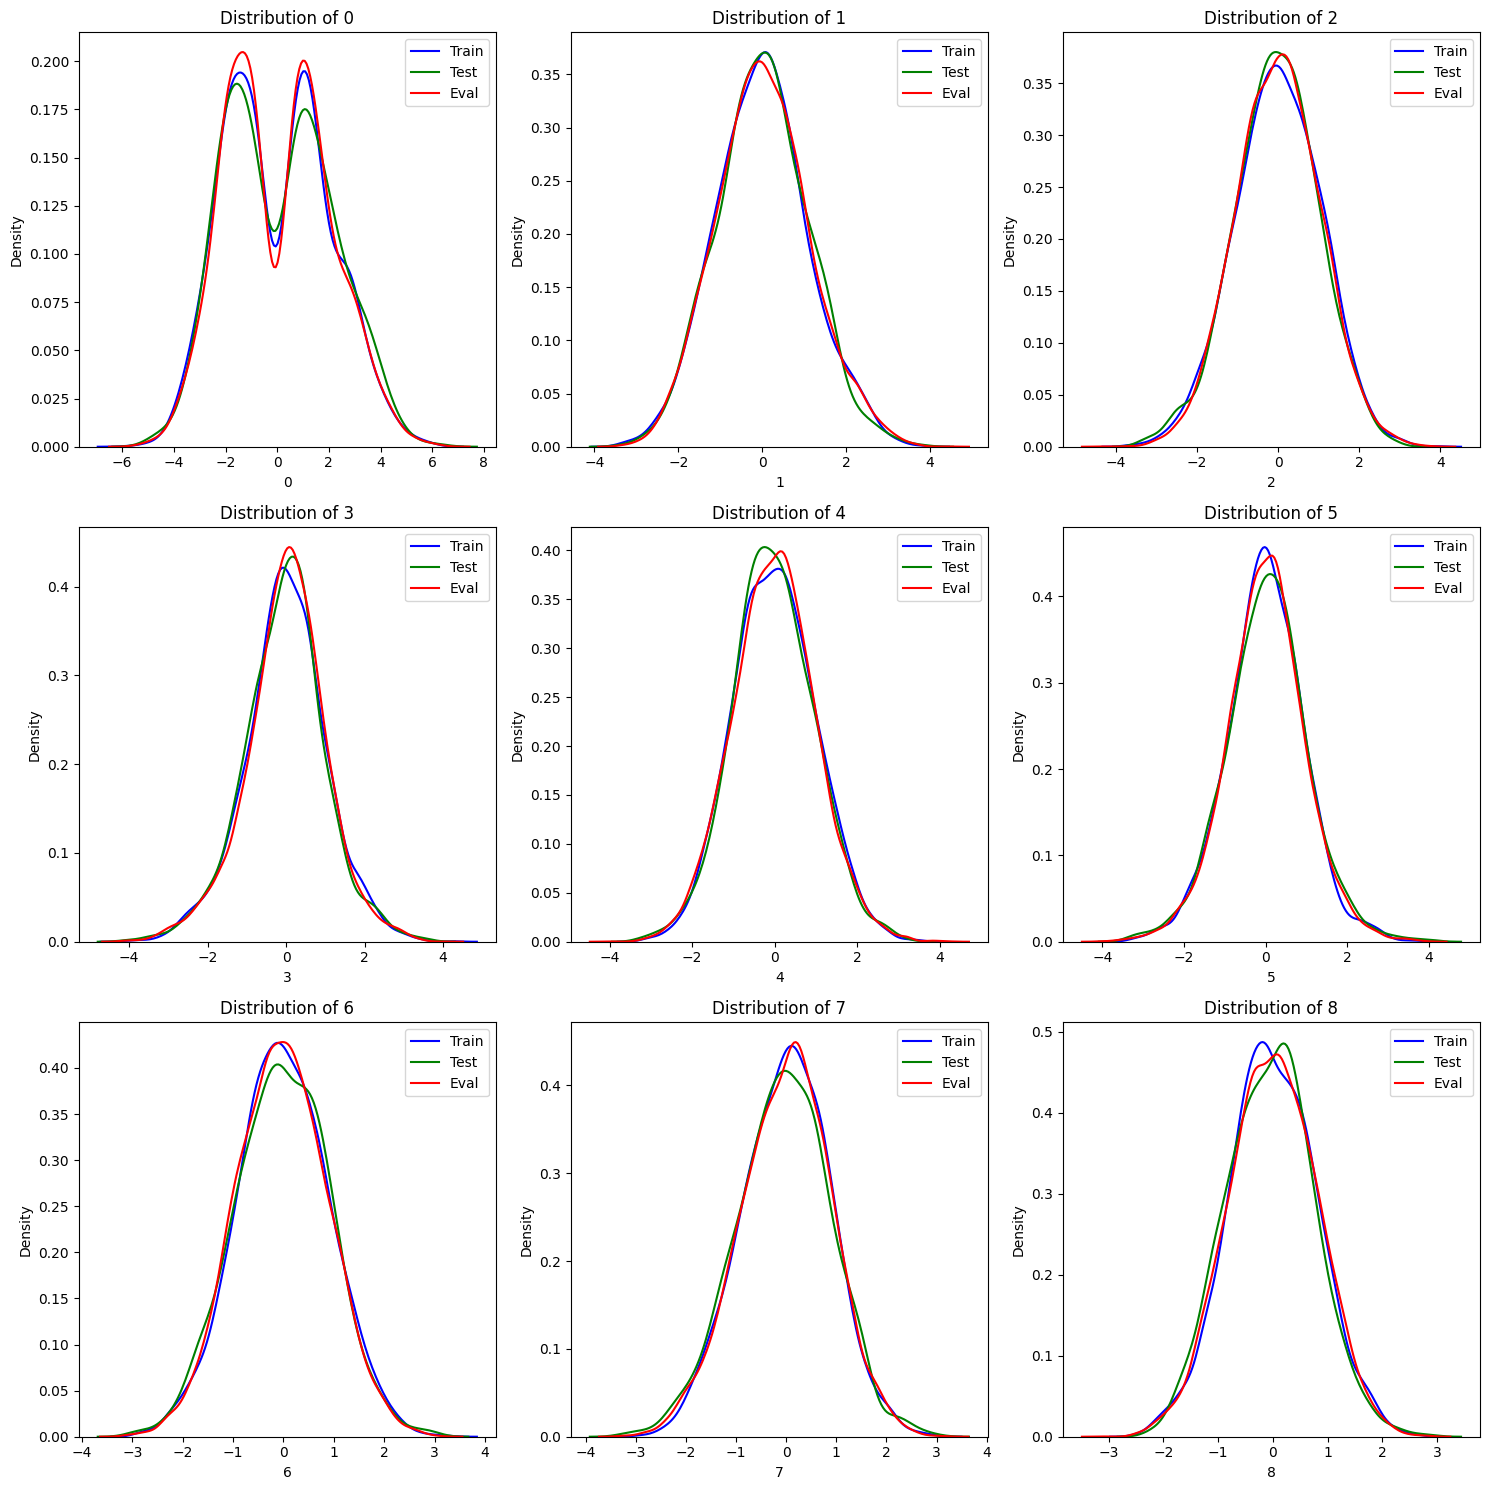

In [52]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

features = X_train.columns

for i, feature in enumerate(features):
    sns.kdeplot(X_train[feature], ax=axs[i], label='Train', color='blue')
    sns.kdeplot(X_test[feature], ax=axs[i], label='Test', color='green')
    sns.kdeplot(X_eval[feature], ax=axs[i], label='Eval', color='red')

    axs[i].set_title(f'Distribution of {feature}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## K-Nearest Neighbors

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters :  {'n_neighbors': 50}
Classification report :
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       338
           1       0.67      0.79      0.73       403
           2       0.65      0.42      0.51       259

    accuracy                           0.67      1000
   macro avg       0.66      0.64      0.64      1000
weighted avg       0.67      0.67      0.66      1000

Accuracy on test set:  0.668
Accuracy on training set:  0.68925


<Figure size 600x600 with 0 Axes>

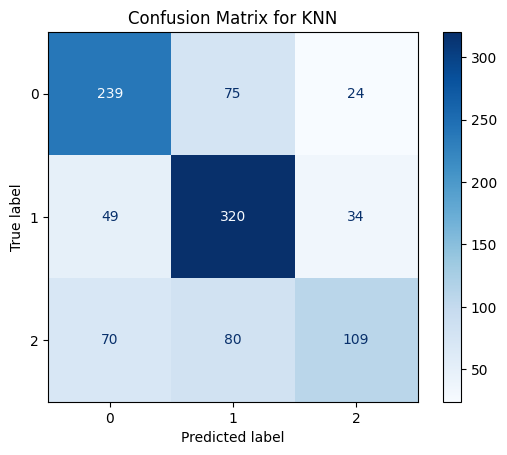

In [48]:
knn = KNeighborsClassifier()

# hyperparameters tuning
param_grid = {
    'n_neighbors': [5, 10, 20, 30, 50, 60, 70, 80, 100, 200],
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)


# results
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)
y_pred_train = best_knn.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_knn))

print("Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("Accuracy on training set: ", accuracy_score(y_train, y_pred_train))


# confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm_knn).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix for KNN')
plt.show()

## Support Vector Machine

### Polynomial Kernel

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters :  {'C': 100, 'degree': 2, 'kernel': 'poly'}
Classification report :
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       338
           1       0.61      0.58      0.59       403
           2       0.61      0.47      0.53       259

    accuracy                           0.60      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.60      0.60      1000

Accuracy :  0.602
Accuracy on training set :  0.617


<Figure size 600x600 with 0 Axes>

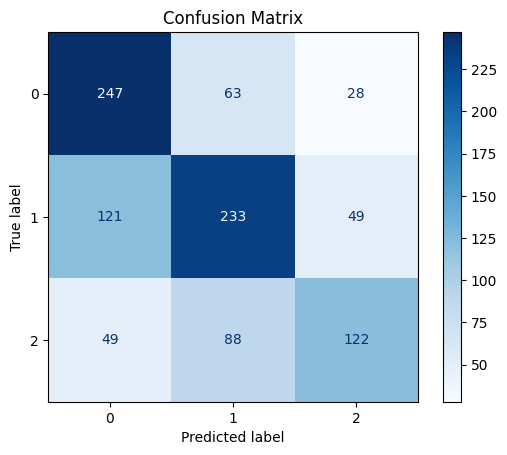

In [177]:
svm = SVC(random_state=32)

# hyperparameters tuning
param_grid = {
     'C': [0.1, 1, 10, 100],
     'kernel': ['poly'],
     'degree': [2, 4, 6, 10, 15, 20]
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)


# results
best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_pred_train = best_svm.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_svm))
print("Accuracy : ", accuracy_score(y_test, y_pred_svm))
print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))


# confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()

### RBF Kernel

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters :  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Classification report :
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       338
           1       0.69      0.78      0.73       403
           2       0.61      0.54      0.57       259

    accuracy                           0.68      1000
   macro avg       0.67      0.66      0.67      1000
weighted avg       0.68      0.68      0.68      1000

Accuracy :  0.682
Accuracy on training set :  0.75175


<Figure size 600x600 with 0 Axes>

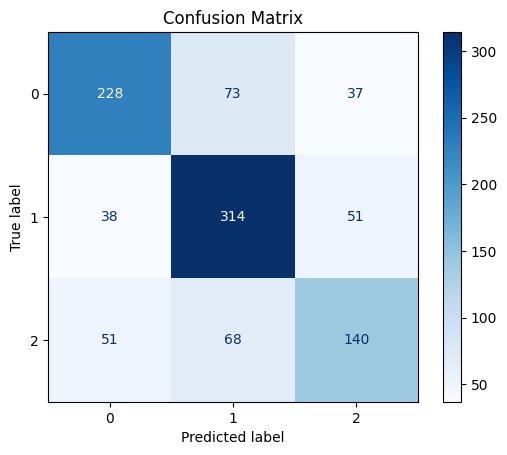

In [217]:
svm = SVC(random_state=32)

# hyperparameters tuning
param_grid = {
     'C': [0.1, 1, 10, 100],
     'kernel': ['rbf'],
     'gamma': [0.001, 0.01, 0.1, 1]
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)


# results
best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_pred_train = best_svm.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_svm))
print("Accuracy : ", accuracy_score(y_test, y_pred_svm))
print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))


# confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()

## Adaboost

### With Naive Bayes Classifier

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost:  {'estimator': GaussianNB(), 'learning_rate': 0.01, 'n_estimators': 50}
Classification report :
              precision    recall  f1-score   support

           0       0.76      0.71      0.73       338
           1       0.68      0.70      0.69       403
           2       0.55      0.57      0.56       259

    accuracy                           0.67      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg       0.67      0.67      0.67      1000

Accuracy :  0.667
Accuracy on training set :  1.0


<Figure size 600x600 with 0 Axes>

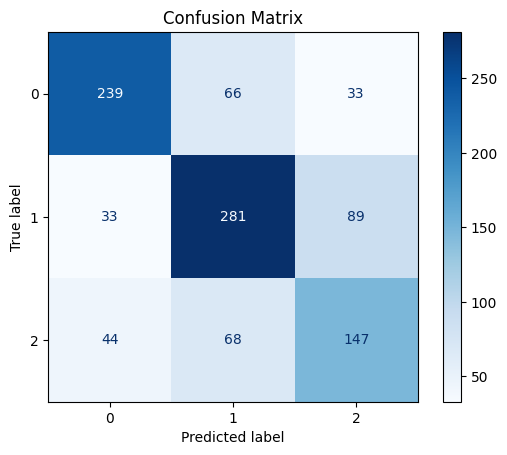

In [218]:
ada = AdaBoostClassifier(random_state=32)

# hyperparameters tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'estimator': [GaussianNB()],
}

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, 
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print("Best parameters for AdaBoost: ", grid_search.best_params_)


# results
best_ada = grid_search.best_estimator_
y_pred_ada = best_ada.predict(X_test)
y_pred_train = best_ada.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_ada))
print("Accuracy : ", accuracy_score(y_test, y_pred_ada))
print("Accuracy on training set : ", accuracy_score(y_pred_train, y_pred_train))


# confusion matrix
cm = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()

### With Decision Tree Classifier

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters for AdaBoost:  {'estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 0.5, 'n_estimators': 200}
Classification report :
              precision    recall  f1-score   support

           0       0.75      0.65      0.70       338
           1       0.66      0.78      0.71       403
           2       0.60      0.53      0.56       259

    accuracy                           0.67      1000
   macro avg       0.67      0.65      0.66      1000
weighted avg       0.67      0.67      0.67      1000

Accuracy :  0.671
Accuracy on training set :  1.0


<Figure size 600x600 with 0 Axes>

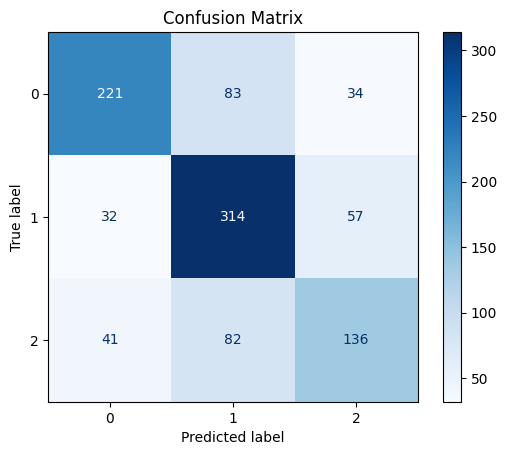

In [219]:
ada = AdaBoostClassifier(random_state=32)

# hyperparameters tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [1, 2, 3, 5, 8, 10]],
}

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, 
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print("Best parameters for AdaBoost: ", grid_search.best_params_)


# results
best_ada = grid_search.best_estimator_
y_pred_ada = best_ada.predict(X_test)
y_pred_train = best_ada.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_ada))
print("Accuracy : ", accuracy_score(y_test, y_pred_ada))
print("Accuracy on training set : ", accuracy_score(y_pred_train, y_pred_train))


# confusion matrix
cm = confusion_matrix(y_test, y_pred_ada)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()

## Random Forest

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best parameters :  {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Classification report :
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       338
           1       0.70      0.75      0.73       403
           2       0.60      0.58      0.59       259

    accuracy                           0.69      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.69      0.69      0.69      1000

Accuracy :  0.691
Accuracy on training set :  0.991


<Figure size 600x600 with 0 Axes>

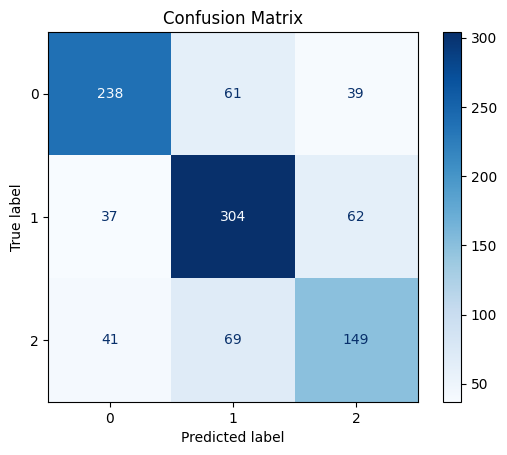

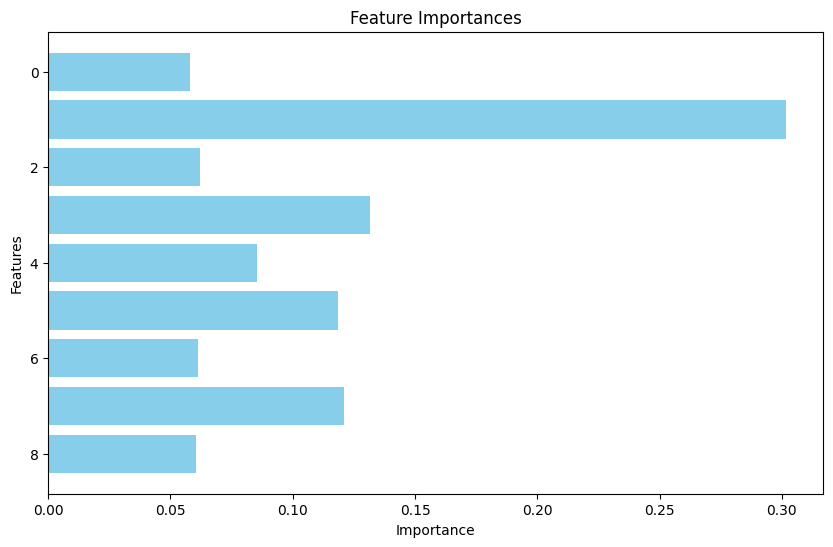

In [53]:
rf = RandomForestClassifier(random_state=32)

# hyperparameters tuning
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Best parameters : ", grid_search.best_params_)


# results
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_train = best_rf.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_rf))
print("Accuracy : ", accuracy_score(y_test, y_pred_rf))
print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))


# confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()


# features importance
importances = best_rf.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## XG Boost

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters :  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}
Classification report :
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       338
           1       0.72      0.75      0.74       403
           2       0.61      0.61      0.61       259

    accuracy                           0.70      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.70      0.70      0.70      1000

Accuracy :  0.702
Accuracy on training set :  0.79225


<Figure size 600x600 with 0 Axes>

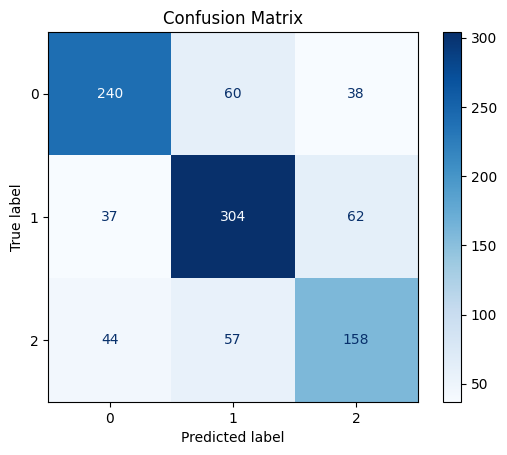

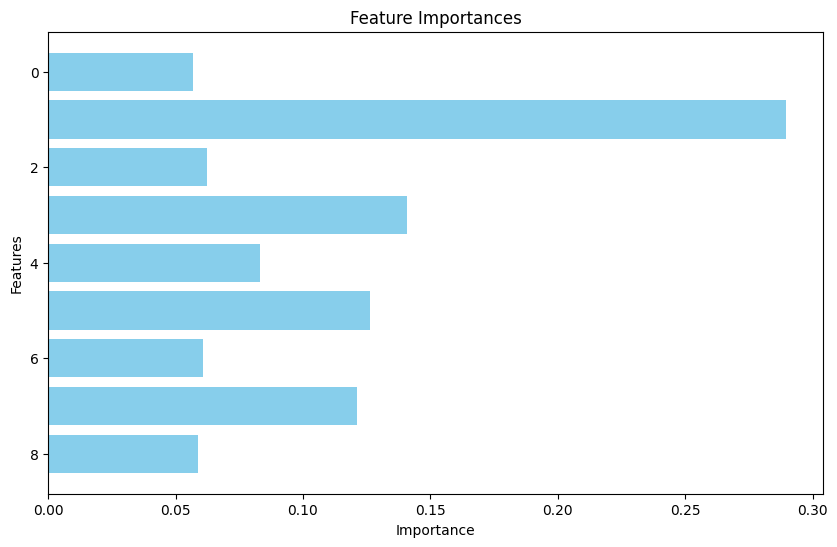

In [49]:
xg = XGBClassifier(objective='multi:softmax', random_state=32)

# hyperparameters tuning
param_grid = {
    'n_estimators': [50, 60, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xg, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)

# results
best_xg = grid_search.best_estimator_
y_pred_xg = best_xg.predict(X_test)
y_pred_train = best_xg.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_xg))
print("Accuracy : ", accuracy_score(y_test, y_pred_xg))
print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_xg)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()


# features importance
importances = best_xg.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## Neural Network

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\cleme\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters :  {'batch_size': 16, 'epochs': 100, 'model__learning_rate': 0.01, 'model__n_hidden': 2, 'model__n_neurons': 30}
Classification report :
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       338
           1       0.73      0.77      0.75       403
           2       0.62      0.59      0.60       259

    accuracy                           0.71      1000
   macro avg       0.70      0.69      0.69      1000
weighted avg       0.70      0.71      0.71      1000

Accuracy :  0.706
Accuracy on training set :  0.74025


<Figure size 600x600 with 0 Axes>

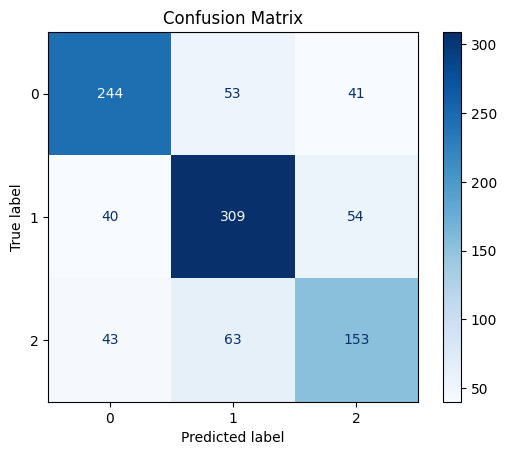

In [54]:
def create_model(learning_rate=0.01, n_hidden=1, n_neurons=30, activation='relu'):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation, kernel_initializer=tf.keras.initializers.RandomNormal(seed=32)))
        
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

nn = KerasClassifier(model=create_model, verbose=0)

# hyperparameters tuning
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__n_hidden': [2, 3],
    'model__n_neurons': [30, 50, 70],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100]
}

grid_search = GridSearchCV(estimator=nn, param_grid=param_grid, 
                    scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)

# results
best_nn = grid_search.best_estimator_
y_pred_nn = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

print("Classification report :")
print(classification_report(y_test, y_pred_nn))
print("Accuracy : ", accuracy_score(y_test, y_pred_nn))
print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))

# confusion matrix
cm = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm).plot(cmap="Blues", colorbar=True)
plt.title('Confusion Matrix')
plt.show()

## Save predictions with best model

In [57]:
model = best_nn

encoder = label_encoders['y']

y_eval = model.predict(X_eval)
y_eval = encoder.inverse_transform(y_eval)
y_eval = pd.DataFrame(y_eval, columns=['y'])
y_eval.to_csv('y_pred.txt', index=False, header=False)
y_eval.head()

,y
0,SpaceX
1,TwitterX
2,SpaceX
3,Tesla
4,TwitterX
